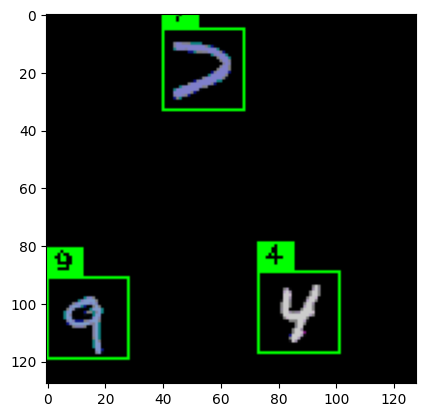

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
import cv2
import matplotlib.pyplot as plt

# preapre handwritten digits
(X_num, y_num), _ = tf.keras.datasets.mnist.load_data()
X_num = np.expand_dims(X_num, axis=-1).astype(np.float32) / 255.0

grid_size = 16  # image_size / mask_size

def make_numbers(X, y):
    for _ in range(3):
        # pickup random index
        idx = np.random.randint(len(X_num))

        # make digit colorful
        number = X_num[idx] @ (np.random.rand(1, 3) + 0.1)
        number[number > 0.1] = np.clip(number[number > 0.1], 0.5, 0.8)
        # class of digit
        kls = y_num[idx]
        
        # random position for digit
        px, py = np.random.randint(0, 100), np.random.randint(0, 100)
        
        # digit belong which mask position
        mx, my = (px+14) // grid_size, (py+14) // grid_size
        channels = y[my][mx]

        # prevent duplicated problem
        if channels[0] > 0:
            continue
            
        channels[0] = 1.0
        channels[1] = px - (mx * grid_size)  # x1
        channels[2] = py - (my * grid_size)  # y1
        channels[3] = 28.0      # x2, in this demo image only 28 px as width
        channels[4] = 28.0      # y2, in this demo image only 28 px as height
        channels[5 + kls] = 1.0
        
        # put digit in X
        X[py:py+28, px:px+28] += number
        

def make_data(size=64):
    X = np.zeros((size, 128, 128, 3), dtype=np.float32)
    y = np.zeros((size, 8, 8, 15), dtype=np.float32)
    for i in range(size):
        make_numbers(X[i], y[i])
        
    X = np.clip(X, 0.0, 1.0)
    return X, y

def get_color_by_probability(p):
    if p < 0.3:
        return (1., 0., 0.)
    if p < 0.7:
        return (1., 1., 0.)
    return (0., 1., 0.)

def show_predict(X, y, threshold=0.1):
    X = X.copy()
    for mx in range(8):
        for my in range(8):
            channels = y[my][mx]
            prob, x1, y1, x2, y2 = channels[:5]

            # if prob < threshold we won't show any thing
            if prob < threshold:
                continue
                
            color = get_color_by_probability(prob)
            # bounding box
            px, py = (mx * grid_size) + x1, (my * grid_size) + y1
            cv2.rectangle(X, (int(px), int(py)), (int(px + x2), int(py + y2)), color, 1)
            
            # label
            cv2.rectangle(X, (int(px), int(py - 10)), (int(px + 12), int(py)), color, -1)
            kls = np.argmax(channels[5:])
            cv2.putText(X, f'{kls}', (int(px + 2), int(py-2)), cv2.FONT_HERSHEY_PLAIN, 0.7, (0.0, 0.0, 0.0))

    plt.imshow(X)

# test
X, y = make_data(size=1)
show_predict(X[0], y[0])

In [ ]:
x = x_input = layers.Input(shape=(128, 128, 3))

x = layers.Conv2D(32, kernel_size=3, padding='same', activation='relu')(x)
x = layers.MaxPool2D()(x)
x = layers.BatchNormalization()(x) # size: 64x64

x = layers.Conv2D(32, kernel_size=3, padding='same', activation='relu')(x)
x = layers.BatchNormalization()(x)  # size: 64x64

x = layers.Conv2D(32, kernel_size=3, padding='same', activation='relu')(x)
x = layers.MaxPool2D()(x)
x = layers.BatchNormalization()(x)  # size: 32x32

x = layers.Conv2D(32, kernel_size=3, padding='same', activation='relu')(x)
x = layers.MaxPool2D()(x)
x = layers.BatchNormalization()(x)  # size: 16x16

x = layers.Conv2D(32, kernel_size=3, padding='same', activation='relu')(x)
x = layers.MaxPool2D()(x)
x = layers.BatchNormalization()(x) # size: 8x8x

# ---

x_prob = layers.Conv2D(1, kernel_size=3, padding='same', activation='sigmoid', name='x_prob')(x)
x_boxes = layers.Conv2D(4, kernel_size=3, padding='same', name='x_boxes')(x)
x_cls = layers.Conv2D(10, kernel_size=3, padding='same', activation='sigmoid', name='x_cls')(x)

# ---

gate = tf.where(x_prob > 0.5, tf.ones_like(x_prob), tf.zeros_like(x_prob))
x_boxes = x_boxes * gate
x_cls = x_cls * gate

# ---

x = layers.Concatenate()([x_prob, x_boxes, x_cls])

model = tf.keras.models.Model(x_input, x)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_2 (Conv2D)              (None, 128, 128, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d_2 (MaxPooling2D)  (None, 64, 64, 32)  0           ['conv2d_2[0][0]']               
                                                                                              

In [ ]:
x = x_input = layers.Input(shape=(128, 128, 3))
x = layers.Conv2D(32, kernel_size=3, padding='same', activation='relu')(x)
x = layers.MaxPool2D()(x)
x = layers.BatchNormalization()(x) # size: 64x64
x = layers.Conv2D(32, kernel_size=3, padding='same', activation='relu')(x)
x = layers.BatchNormalization()(x)  # size: 64x64
x = layers.Conv2D(32, kernel_size=3, padding='same', activation='relu')(x)
x = layers.MaxPool2D()(x)
x = layers.BatchNormalization()(x)  # size: 32x32
x = layers.Conv2D(32, kernel_size=3, padding='same', activation='relu')(x)
x = layers.MaxPool2D()(x)
x = layers.BatchNormalization()(x)  # size: 16x16
x = layers.Conv2D(32, kernel_size=3, padding='same', activation='relu')(x)
x = layers.MaxPool2D()(x)
x = layers.BatchNormalization()(x) # size: 8x8x

In [ ]:
x_prob = layers.Conv2D(1, kernel_size=3, padding='same', activation='sigmoid', name='x_prob')(x)
x_boxes = layers.Conv2D(4, kernel_size=3, padding='same', name='x_boxes')(x)
x_cls = layers.Conv2D(10, kernel_size=3, padding='same', activation='sigmoid', name='x_cls')(x)

In [ ]:
gate = tf.where(x_prob > 0.5, tf.ones_like(x_prob), tf.zeros_like(x_prob))
x_boxes = x_boxes * gate
x_cls = x_cls * gate

In [ ]:
x = layers.Concatenate()([x_prob, x_boxes, x_cls])
model = tf.keras.models.Model(x_input, x)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_7 (Conv2D)              (None, 128, 128, 32  896         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d_6 (MaxPooling2D)  (None, 64, 64, 32)  0           ['conv2d_7[0][0]']               
                                                                                            

In [ ]:
idx_p = [0]
idx_bb = [1, 2, 3, 4]
idx_cls = [5, 6, 7, 8, 9, 10, 11, 12, 13, 14]

@tf.function
def loss_bb(y_true, y_pred):
    y_true = tf.gather(y_true, idx_bb, axis=-1)
    y_pred = tf.gather(y_pred, idx_bb, axis=-1)

    loss = tf.keras.losses.mean_squared_error(y_true, y_pred)
    return tf.reduce_mean(loss[loss > 0.0])

@tf.function
def loss_p(y_true, y_pred):
    y_true = tf.gather(y_true, idx_p, axis=-1)
    y_pred = tf.gather(y_pred, idx_p, axis=-1)
    
    loss = tf.losses.binary_crossentropy(y_true, y_pred)
    return tf.reduce_sum(loss)

@tf.function
def loss_cls(y_true, y_pred):
    y_true = tf.gather(y_true, idx_cls, axis=-1)
    y_pred = tf.gather(y_pred, idx_cls, axis=-1)
    
    loss = tf.losses.binary_crossentropy(y_true, y_pred)
    return tf.reduce_sum(loss)

@tf.function
def loss_func(y_true, y_pred):
    return loss_bb(y_true, y_pred) + loss_p(y_true, y_pred) + loss_cls(y_true, y_pred)

opt = tf.keras.optimizers.Adam(learning_rate=0.003)
model.compile(loss=loss_func, optimizer=opt)

1/1 [==============================] - 8s 8s/step


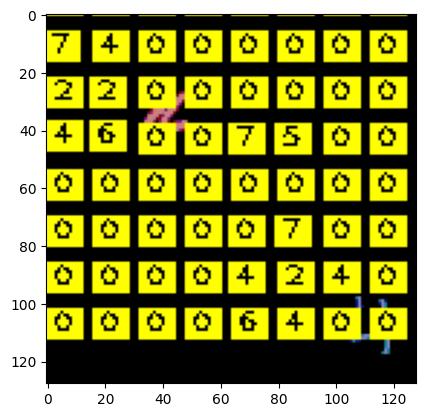

In [ ]:
def preview(numbers=None, threshold=0.1):
    X, y = make_data(size=1)
    y = model.predict(X)
    show_predict(X[0], y[0], threshold=threshold)
preview()

In [ ]:
batch_size = 32
X_train, y_train = make_data(size=batch_size * 400)

In [ ]:
model.fit(X_train, y_train, batch_size=batch_size, epochs=30, shuffle=True)

Epoch 1/30
400/400 [==============================] - 16s 19ms/step - loss: 203.7963
Epoch 2/30
400/400 [==============================] - 8s 19ms/step - loss: 102.2282
Epoch 3/30
400/400 [==============================] - 7s 19ms/step - loss: 87.6547
Epoch 4/30
400/400 [==============================] - 8s 19ms/step - loss: 76.6890
Epoch 5/30
400/400 [==============================] - 8s 19ms/step - loss: 70.3933
Epoch 6/30
400/400 [==============================] - 8s 19ms/step - loss: 64.8143
Epoch 7/30
400/400 [==============================] - 8s 19ms/step - loss: 60.6611
Epoch 8/30
400/400 [==============================] - 7s 19ms/step - loss: 59.8817
Epoch 9/30
400/400 [==============================] - 9s 21ms/step - loss: 53.0312
Epoch 10/30
400/400 [==============================] - 8s 19ms/step - loss: 49.1449
Epoch 11/30
400/400 [==============================] - 7s 19ms/step - loss: 46.8339
Epoch 12/30
400/400 [==============================] - 8s 19ms/step - loss: 42.642

1/1 [==============================] - 0s 20ms/step


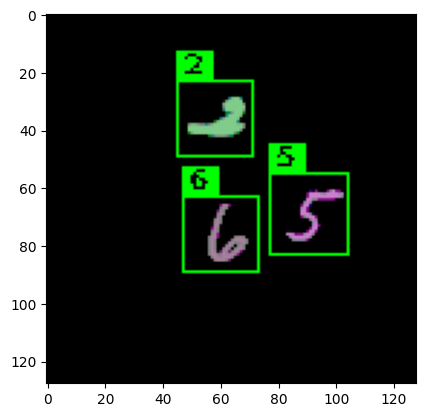

In [ ]:
preview(threshold=0.7)